In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import uniform
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from prince import FAMD

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

### Exploratory Data Analysis

In [2]:
data = pd.read_csv('.\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Data overview
print("Total rows: ", data.shape[0])
print("Total features: ", data.shape[1])
data.drop('customerID', axis=1, inplace=True) # Useless feature for both data analysis and model training.
data.head()

Total rows:  7043
Total features:  21


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Check for null values and data types
data.info()

# NOTE: There are no null values in the dataset. There are 3 numerical features and 18 categorical features.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


As we can see there could be some errors in the dataset. TotalCharges should be a numeric value, but its Dtype is object. Also note that SeniorCitizen is actually a categorical feature but it is encoded as a numeric value (0s and 1s).

In [4]:
data.SeniorCitizen = data.SeniorCitizen.replace({1: 'Yes', 0: 'No'})
data[data['TotalCharges'] == " "] # Check for empty strings in TotalCharges column

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [5]:
data[data['tenure'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


The rows with missing values in TotalCharges column are the same rows with 0 in tenure column. This means that these customers have not been charged yet because they have just started using the service. We could replace the missing values with 0 or their monthly rate. However, if our analysis is focused on customers who have been with the company for some time or who have churned these cases are very few and not representative of the dataset and could introduce bias in the model. Therefore, we will drop these rows.

In [6]:
data.drop(labels=data[data["TotalCharges"] == " "].index, axis = 0, inplace = True)
data['TotalCharges'] = pd.to_numeric(data.TotalCharges, errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   object 
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

In [7]:
# describe numerical features
data.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [8]:
# describe categorical features
data.describe(include=['O'])

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3549,5890,3639,4933,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,5163


In [9]:
# Pie chart for Churn
fig = px.pie(data, names='Churn', title='Churn distribution')
fig.show()

# NOTE: Distribution of customer churn. This is the target variable. The dataset 
# is imbalanced with 73% of customers not churning. We should give more weight 
# to other metrics for example confusion matrix or f1 score.

In [10]:
# Plot histogram for tenure with respect to churn
fig = px.histogram(data, x='tenure', color='Churn', marginal='box', nbins=20, title='Churn rate with respect to tenure')
fig.show()

# NOTE: New customers are more likely to churn.

In [11]:
# Plot histogram for Monthly Charges with respect to churn
fig = px.histogram(data, x="MonthlyCharges", color='Churn', marginal='box', nbins=20, title='Churn rate with respect to Monthly Charges')
fig.show()

# NOTE: The customers with higher monthly charges are more likely to churn.

In [12]:
# Plot histogram for TotalCharges with respect to churn
fig = px.histogram(data, x='TotalCharges', color='Churn', marginal='box', nbins=20, title='Churn rate with respect to Total Charges')
fig.show()

# NOTE: Customers with lower total charges are more likely to churn. This could be
# because they are new customers which is shown in the tenure histogram to be more
# likely to churn.

In [13]:
# create a function to plot categorical features

def plot_categorical(feature):
    fig = go.Figure()
    x, y = [[[],[]],[[],[]]], [[],[]]
    for i in data[feature].unique():
        y[1].append(data[data[feature] == i]['Churn'].value_counts().Yes)
        y[0].append(data[data[feature] == i]['Churn'].value_counts().No)
        x[0][0].append(i)
        x[0][1].append(i)
        x[1][0].append('Churn:No')
        x[1][1].append('Churn:Yes')
    x[0] = x[0][0] + x[0][1]
    x[1] = x[1][0] + x[1][1]
    y = y[0] + y[1]
    fig.add_trace(go.Bar(
        x = x,
        y = y,
        ))

    fig.update_layout(title_text=f"<b>Churn by {feature}")

    fig.show()
        

plot_categorical('gender')

# To avoid bloating the notebook, I will not plot all the categorical features.
# To get the plot of a feature, input the name of the feature above in the function

# gender SeniorCitizen Partner Dependents PhoneService MultipleLines 
# InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport 
# StreamingTV StreamingMovies Contract PaperlessBilling PaymentMethod

#### Encoding categorical features

In [14]:
# Binary encoding

b_features = [
    'Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'PaperlessBilling'
    ]

data[b_features] = data[b_features].replace({'Yes': 1, 'No': 0})
data['gender'] = data['gender'].replace({'Male': 1, 'Female': 0})

# One-hot encoding
oh_features = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]

data = pd.get_dummies(data=data, columns=oh_features, drop_first=True, dtype=int)
data.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0


We do one-hot encoding for the non-binary categorical feature to create a new feature for each category, this way we avoid using label encoding which can lead to the model thinking that the categories have some kind of order or hierarchy. We also drop the first new features (the 'x_no' feature) to avoid multicollinearity since we also have the yes features, this also keeps the consistency with the rest of binary features. However, we end up with a lot of 'X_no_internet_service' features which will likely be highly correlated with each other, but we will be applying Principal Component Analysis (PCA) later on to reduce the dimensionality of the data and avoid multicollinearity.

We will split the data in training and testing sets to avoid any further preprocessing to introduce bias in the model. We will also standardize the continuous (mean = 0 and sd = 1) since PCA is sensitive to variances.

In [16]:
# splitting dataset
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='Churn'), data['Churn'], test_size=0.1, shuffle=False)    # test last 10%

# standardization
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
x_train[num_features] = scaler.fit_transform(x_train[num_features])
x_test[num_features] = scaler.transform(x_test[num_features])

# Covariance matrix
cov_matrix = x_train[num_features].cov()
fig = px.imshow(cov_matrix, width=1000, height=1000)
fig.show()

# NOTE: The covariance matrix of standardized variables is equal to the 
# correlation matrix. The standardization process ensures that each 
# variable has a mean of 0 and a standard deviation of 1, which means that the 
# covariance and correlation of these standardized variables are the same



Since we are dealing with one-hot encoded categorical data, we cannot apply PCA directly. I found [this explanation](https://andrewpwheeler.com/2021/06/22/pca-does-not-make-sense-after-one-hot-encoding/) to be very clear and helpful. Instead, we will use Factor Analysis of Mixed Data (FAMD) to reduce the dimensionality of our data. using the [prince](https://github.com/MaxHalford/prince) package. FAMD is a multivariate method that can handle both quantitative and qualitative variables. It is a generalization of PCA to handle mixed data. It is also a generalization of multiple correspondence analysis (MCA) to handle quantitative variables.

In [17]:
famd = FAMD(n_components=17).fit(x_train)

famd.eigenvalues_summary

# 17 components explain approx 96% of the variance.

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,120.957,32.91%,32.91%
1,35.601,9.69%,42.60%
2,33.520,9.12%,51.72%
3,18.734,5.10%,56.82%
4,16.723,4.55%,61.37%
5,16.635,4.53%,65.90%
6,14.901,4.05%,69.95%
7,13.508,3.68%,73.63%
8,12.380,3.37%,77.00%


In [18]:
# FAMD 
famd = FAMD(17)
x_train_famd = famd.fit_transform(x_train)
x_test_famd = famd.transform(x_test)
x_train_famd.shape, x_test_famd.shape

((6328, 17), (704, 17))

Accuracy:  0.7315340909090909
Recall:  0.7487179487179487
Precision:  0.5104895104895105
F1:  0.6070686070686072
ROC AUC:  0.8168757241448793
Confusion Matrix: 
 [[369 140]
 [ 49 146]]


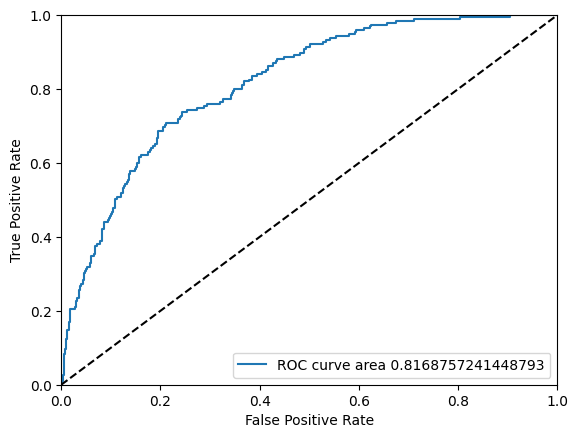

[0.7315340909090909,
 0.7487179487179487,
 0.5104895104895105,
 0.6070686070686072,
 0.8168757241448793]

In [19]:
# Using logistic regression as baseline model

# instantiate model
logreg = LogisticRegression(class_weight="balanced")    # class_weight='balanced' to account for imbalanced classes

# fit model
logreg.fit(x_train_famd, y_train)

# predict
y_pred = logreg.predict(x_test_famd)

# evaluate

def evaluate(y_test, y_pred, model, plt_roc = True, probs = None, p = True):
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, probs[:, 1])
    conf_mat = confusion_matrix(y_test, y_pred)

    if p:
        print('Accuracy: ', acc)
        print('Recall: ', rec)
        print('Precision: ', prec)
        print('F1: ', f1)
        print('ROC AUC: ', roc_auc)
        print('Confusion Matrix: \n', conf_mat)

    if plt_roc:
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, probs[:, 1])
        plt.plot(fpr, tpr, label=f'ROC curve area {roc_auc_score(y_test, probs[:, 1])}')
        plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()
    
    return [acc, rec, prec, f1, roc_auc]

evaluate(y_test, y_pred, logreg, probs = logreg.predict_proba(x_test_famd))

In [20]:
# Applying cross validation

def cross_val(model, x_train, y_train, cv, p = True):
    kf = StratifiedKFold(n_splits=cv, shuffle=True)
    # StratifiedKFold preserves the percentage of samples for each class, since
    # we have an imbalanced dataset, we need to use this method to make sure
    # that the percentage of samples for each class is preserved in each fold
    # The stratification is done based on the target variable.

    accuracy = []
    recall = []
    precision = []
    f1_scores = []
    roc_auc_scores = []

    for train_index, test_index in kf.split(x_train, y_train):
        xtrain, xtest = x_train.iloc[train_index], x_train.iloc[test_index]
        ytrain, ytest = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(xtrain, ytrain)
        pred = model.predict(xtest)

        acc = accuracy_score(ytest, pred)
        accuracy.append(acc)
        rec = recall_score(ytest, pred)
        recall.append(rec)
        pre = precision_score(ytest, pred)
        precision.append(pre)
        f1 = f1_score(ytest, pred)
        f1_scores.append(f1)
        roc_auc = roc_auc_score(ytest, model.predict_proba(xtest)[:,1])
        roc_auc_scores.append(roc_auc)

    if p:
        # Print means and standard deviations
        print('Accuracy: ', np.mean(accuracy), np.std(accuracy))
        print('Recall: ', np.mean(recall), np.std(recall))
        print('Precision: ', np.mean(precision), np.std(precision))
        print('F1: ', np.mean(f1_scores), np.std(f1_scores))
        print('ROC AUC: ', np.mean(roc_auc_scores), np.std(roc_auc_scores))

    return [np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(f1_scores), np.mean(roc_auc_scores)]

cross_val(logreg, x_train_famd, y_train, 10)
    

Accuracy:  0.7316678165056892 0.016908632852381686
Recall:  0.7759552323923582 0.023943208869080752
Precision:  0.4961174977634218 0.020229000840393814
F1:  0.6049608782642929 0.018044726538942665
ROC AUC:  0.8205041001177698 0.015288738107818807


[0.7316678165056892,
 0.7759552323923582,
 0.4961174977634218,
 0.6049608782642929,
 0.8205041001177698]

Accuracy:  0.7244318181818182
Recall:  0.7333333333333333
Precision:  0.5017543859649123
F1:  0.5958333333333333
ROC AUC:  0.7974207848471109
Confusion Matrix: 
 [[367 142]
 [ 52 143]]


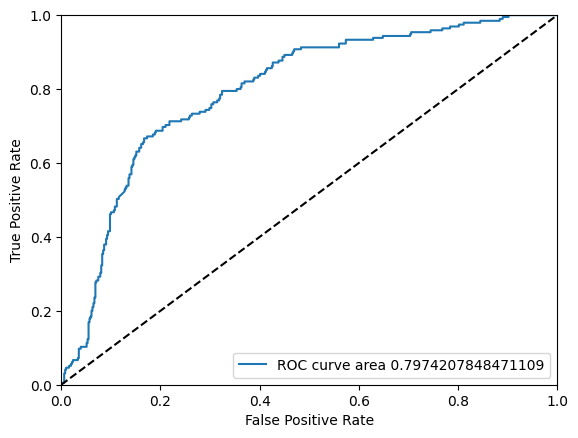

[0.7244318181818182,
 0.7333333333333333,
 0.5017543859649123,
 0.5958333333333333,
 0.7974207848471109]

In [21]:
# Testing with other models

# Support Vector Machine

model = SVC(probability=True, class_weight='balanced')
model.fit(x_train_famd, y_train)
y_pred = model.predict(x_test_famd)

evaluate(y_test, y_pred, model, probs=model.predict_proba(x_test_famd))

Accuracy:  0.7542613636363636
Recall:  0.6512820512820513
Precision:  0.5474137931034483
F1:  0.594847775175644
ROC AUC:  0.8001813510654375
Confusion Matrix: 
 [[404 105]
 [ 68 127]]


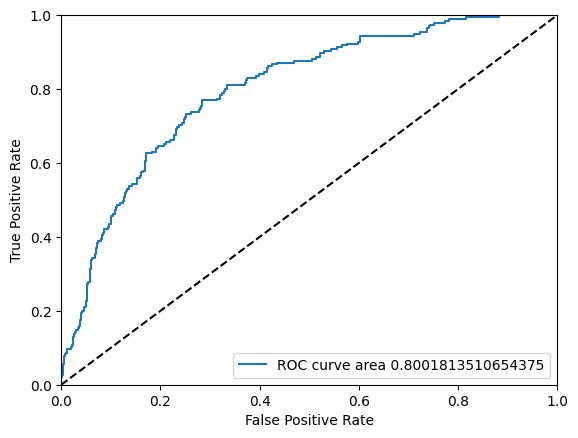

[0.7542613636363636,
 0.6512820512820513,
 0.5474137931034483,
 0.594847775175644,
 0.8001813510654375]

In [22]:
# Naive Bayes

model = GaussianNB()
model.fit(x_train_famd, y_train)
y_pred = model.predict(x_test_famd)

evaluate(y_test, y_pred, model, probs=model.predict_proba(x_test_famd))

Accuracy:  0.7784090909090909
Recall:  0.5333333333333333
Precision:  0.6153846153846154
F1:  0.5714285714285715
ROC AUC:  0.8030325928164829
Confusion Matrix: 
 [[444  65]
 [ 91 104]]


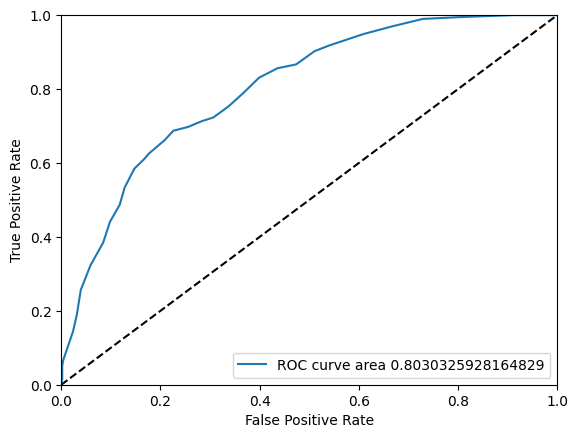

In [23]:
# K-Nearest Neighbors (KNN) Classification

model = KNeighborsClassifier(n_neighbors = 41)
model.fit(x_train_famd.values, y_train.values)
y_pred = model.predict(x_test_famd.values)

knn_res = evaluate(y_test.values, y_pred, model, probs=model.predict_proba(x_test_famd.values))

The optimal number of neighbors is 41


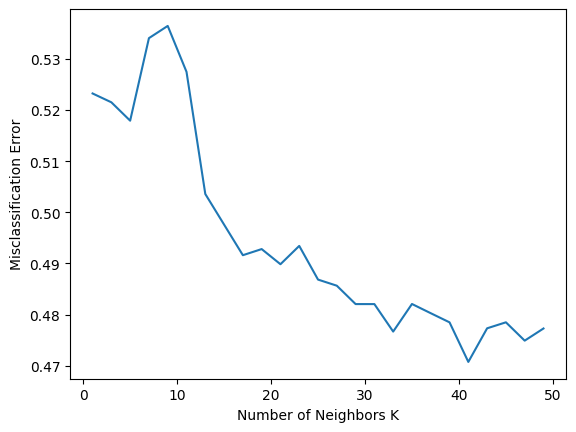

In [24]:
# Choosing best number of neighbors for KNN based on recall score (It is the same K for f1, precision and accuracy as well) 
# We optimize for recall score because we want to minimize false negatives (i.e. we want to minimize the number of customers 
# who churned but we predicted them as not churned). Accuracy is not a good metric for this problem because the data is imbalanced.
# Another important metric in this case could be precision or the f1 score.


neighbors = list(range(1, 50, 2))
cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_famd.values, y_train.values, cv=10, scoring='recall')
    cv_scores.append(scores.mean())

missclassification_err = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[missclassification_err.index(min(missclassification_err))]

print('The optimal number of neighbors is %d' % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, missclassification_err)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

Accuracy:  0.7059659090909091
Recall:  0.4307692307692308
Precision:  0.4666666666666667
F1:  0.44800000000000006
ROC AUC:  0.6210820613571104
Confusion Matrix: 
 [[413  96]
 [111  84]]


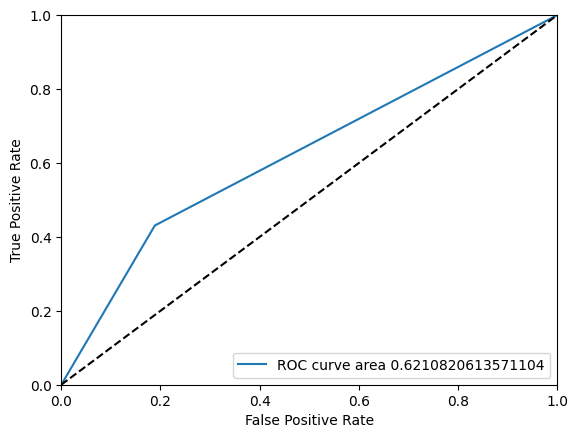

[0.7059659090909091,
 0.4307692307692308,
 0.4666666666666667,
 0.44800000000000006,
 0.6210820613571104]

In [25]:
# Decision Tree Classifier

model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
model.fit(x_train_famd, y_train)
y_pred = model.predict(x_test_famd)

evaluate(y_test, y_pred, model, probs=model.predict_proba(x_test_famd))

Accuracy:  0.7613636363636364
Recall:  0.37435897435897436
Precision:  0.6134453781512605
F1:  0.46496815286624205
ROC AUC:  0.7849025238023273
Confusion Matrix: 
 [[463  46]
 [122  73]]


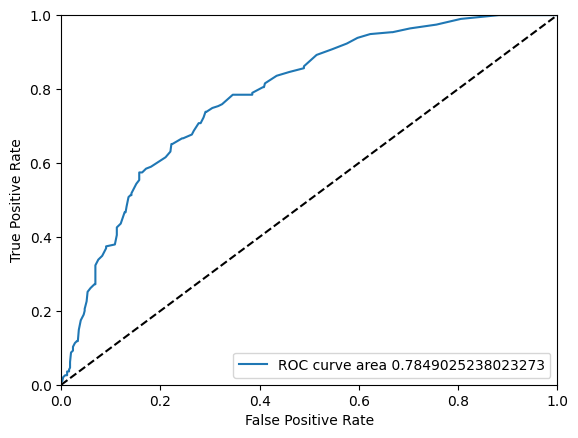

[0.7613636363636364,
 0.37435897435897436,
 0.6134453781512605,
 0.46496815286624205,
 0.7849025238023273]

In [29]:
# Test some ensemble methods

# Random Forest

model = RandomForestClassifier(n_estimators=81, criterion = 'entropy', class_weight='balanced')
model.fit(x_train_famd, y_train)
y_pred = model.predict(x_test_famd)

evaluate(y_test, y_pred, model, probs=model.predict_proba(x_test_famd))

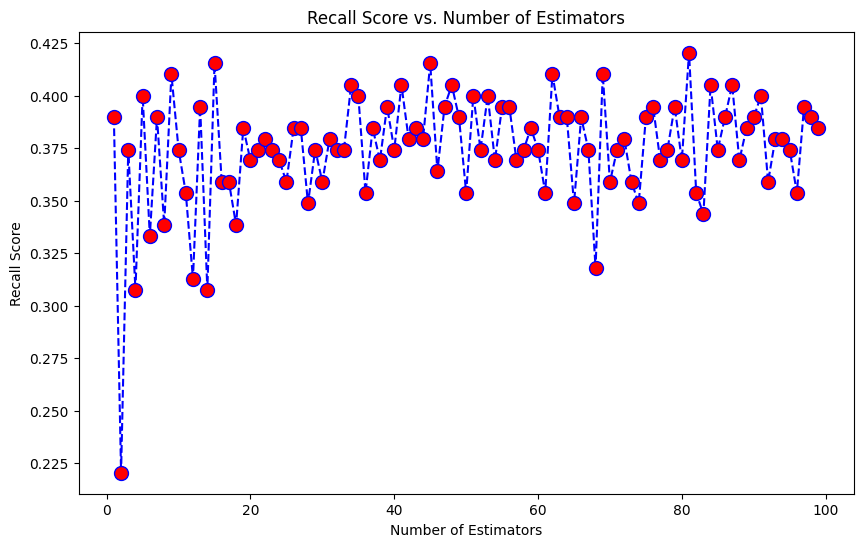

Maximum Recall score:  0.4205128205128205
Number of estimators:  81


In [27]:
# Choosing the best number of estimators for the Random Forest Classifier based on the recall score ~3 mins

recall_scores = []

for i in range(1, 100):
    model = RandomForestClassifier(n_estimators=i, criterion='entropy', class_weight='balanced')
    model.fit(x_train_famd, y_train)
    pred = model.predict(x_test_famd)
    recall_scores.append(recall_score(y_test, pred))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 100), recall_scores, color='blue', linestyle='dashed', marker='o',
            markerfacecolor='red', markersize=10)
plt.title('Recall Score vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Recall Score')
plt.show()

print('Maximum Recall score: ', max(recall_scores))
print('Number of estimators: ', recall_scores.index(max(recall_scores)) + 1)

Accuracy:  0.7670454545454546
Recall:  0.4512820512820513
Precision:  0.6068965517241379
F1:  0.5176470588235293
ROC AUC:  0.8121555589139087
Confusion Matrix: 
 [[452  57]
 [107  88]]


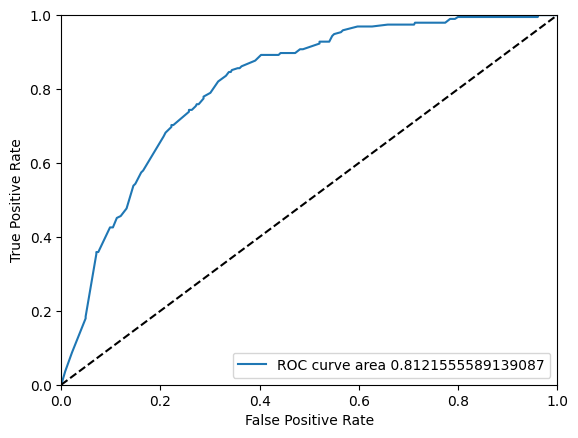

[0.7670454545454546,
 0.4512820512820513,
 0.6068965517241379,
 0.5176470588235293,
 0.8121555589139087]

In [28]:
# Adaboost Classifier

model = AdaBoostClassifier(n_estimators=13)
model.fit(x_train_famd, y_train)
y_pred = model.predict(x_test_famd)

evaluate(y_test, y_pred, model, probs=model.predict_proba(x_test_famd))

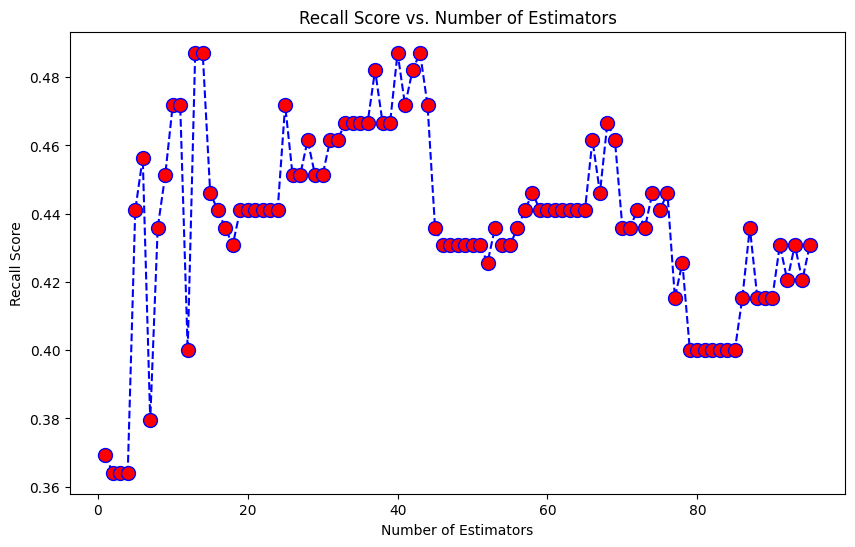

Maximum recall score:  0.48717948717948717
Number of estimators:  13


In [30]:
# Choosing the best number of estimators for the AdaBoost Classifier based on the recall score ~2 mins

recall_scores = []

for i in range(5, 100):
    model = AdaBoostClassifier(n_estimators=i)
    model.fit(x_train_famd, y_train)
    pred = model.predict(x_test_famd)
    recall_scores.append(recall_score(y_test, pred))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 96), recall_scores, color='blue', linestyle='dashed', marker='o',
            markerfacecolor='red', markersize=10)
plt.title('Recall Score vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Recall Score')
plt.show()

print('Maximum recall score: ', max(recall_scores))
print('Number of estimators: ', recall_scores.index(max(recall_scores)) + 1)

In [31]:
# Comparing results

print('Logistic Regression')
logreg_results = cross_val(logreg, x_train_famd, y_train, 5, p=False)
print('SVM')
svm_results = cross_val(SVC(probability=True, class_weight='balanced'), x_train_famd, y_train, 5, p=False)
print('Naive Bayes')
gnb_results = cross_val(GaussianNB(), x_train_famd, y_train, 5, p=False)
print('KNN')
knn_results = knn_res
print('Decision Tree')
dtc_results = cross_val(DecisionTreeClassifier(criterion='entropy', class_weight='balanced'), x_train_famd, y_train, 5, p=False)
print('Random Forest')
rfc_results = cross_val(RandomForestClassifier(n_estimators=13, criterion = 'entropy', class_weight='balanced'), x_train_famd, y_train, 5, p=False)
print('AdaBoost')
abc_results = cross_val(AdaBoostClassifier(n_estimators=13), x_train_famd, y_train, 5, p=False)


df = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1', 'ROC AUC'])
# Add the results to the dataframe
df.loc['Logistic Regression'] = logreg_results
df.loc['SVM'] = svm_results
df.loc['Naive Bayes'] = gnb_results
df.loc['KNN'] = knn_results
df.loc['Decision Tree'] = dtc_results
df.loc['Random Forest'] = rfc_results
df.loc['AdaBoost'] = abc_results

df

Logistic Regression
SVM
Naive Bayes
KNN
Decision Tree
Random Forest
AdaBoost


,Accuracy,Recall,Precision,F1,ROC AUC
Logistic Regression,0.729775,0.768825,0.493348,0.600982,0.819844
SVM,0.726452,0.789720,0.489594,0.604387,0.811791
Naive Bayes,0.757267,0.687568,0.532061,0.599840,0.802647
KNN,0.778409,0.533333,0.615385,0.571429,0.803033
Decision Tree,0.712230,0.461158,0.456431,0.458749,0.631619
Random Forest,0.747788,0.412189,0.530024,0.463652,0.746647
AdaBoost,0.776232,0.475496,0.597197,0.528384,0.809500


In [32]:
# Sort by recall, then precision, then accuracy
df.sort_values(by=['Recall', 'Precision', 'Accuracy'], ascending=False)

# NOTE:
# Highest recall: SVM
# Highest precision: KNN
# Highest accuracy: KNN
# Highest F1: Logistic Regression
# Highest AUC: Logistic Regression

,Accuracy,Recall,Precision,F1,ROC AUC
SVM,0.726452,0.789720,0.489594,0.604387,0.811791
Logistic Regression,0.729775,0.768825,0.493348,0.600982,0.819844
Naive Bayes,0.757267,0.687568,0.532061,0.599840,0.802647
KNN,0.778409,0.533333,0.615385,0.571429,0.803033
AdaBoost,0.776232,0.475496,0.597197,0.528384,0.809500
Decision Tree,0.712230,0.461158,0.456431,0.458749,0.631619
Random Forest,0.747788,0.412189,0.530024,0.463652,0.746647


The support vector machine classifier has the highest recall with an average of ~0.79, indicating that the model is able to correctly identify 79% of the customers who are likely to churn. However, the precision is lower with an average of ~0.49. This means that if the model predicts a customer will churn, there is only a 49% chance that the customer will actually churn, leading to a high rate of false positives. If the cost of false negatives (failing to identify customers who will churn) is much higher than the cost of false positives (erroneously identifying customers as likely to churn), this SVM model could be a good choice. Otherwise, if false positives is a concern, I suggest using KNN with higher precision and accuracy.

SVM is followed by Logistic Regression and Naive Bayes in terms of recall and they also have similar f1 scores (indicating that precision and recall are similarly balanced). One potential approach to improve overall performance is to use a voting classifier to combine these models.

Accuracy:  0.7741477272727273
Recall:  0.6871794871794872
Precision:  0.5775862068965517
F1:  0.6276346604215456
ROC AUC:  0.8163115208301849
Confusion Matrix: 
 [[411  98]
 [ 61 134]]


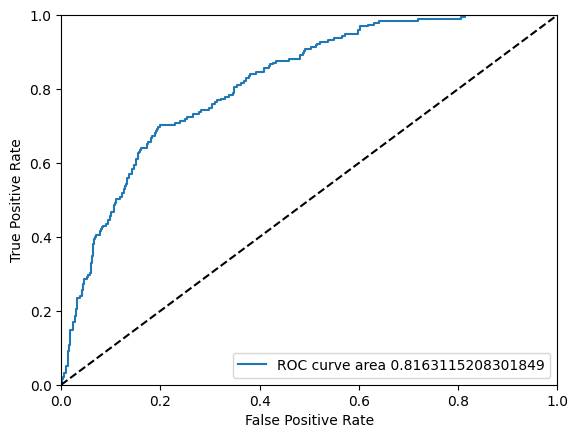

[0.7741477272727273,
 0.6871794871794872,
 0.5775862068965517,
 0.6276346604215456,
 0.8163115208301849]

In [33]:
# Voting Classifier

model = VotingClassifier(
    estimators=[
        ('svc', SVC(probability=True, class_weight='balanced')),
        ('lr', logreg),
        ('gnb', GaussianNB()),
    ],
    voting='soft'
)

model.fit(x_train_famd, y_train)
y_pred = model.predict(x_test_famd)

evaluate(y_test, y_pred, model, probs=model.predict_proba(x_test_famd))

The combined model has higher accuracy, precision, and F1 scores and maintains a similar ROC AUC score than the individual models, suggesting that it performs better overall. However, its recall is lower than that of the SVM and Logistic Regression models. This could be because the combined model is more conservative in predicting positives, leading to fewer false positives but also more false negatives.

The SVM model remains the best choice if minimizing false negatives is a priority, However, if you're looking for a model that balances accuracy, precision, and F1 score the combined model is the best option.

Finally, we will be trying a hybrid neural network approach discussed in the paper [Tsai, C.-F., & Lu, Y.-H. (2009). Customer churn prediction by hybrid neural networks.](https://www.sciencedirect.com/science/article/abs/pii/S0957417409004758).

In this paper, Tsai and Lu propose two hybrid models for customer churn prediction. The models combine two different neural network techniques: back-propagation artificial neural networks (ANN) and self-organizing maps (SOM). The first technique in each hybrid model filters out unrepresentative training data, and the remaining data is used to create a prediction model based on the second technique. The authors found that these hybrid models outperformed a single neural network model in terms of prediction accuracy and Types I and II errors.

We will be implementing the ANN-ANN model proposed in the paper. The model consists of two stages:

- Data reduction: An ANN is used to filter out unrepresentative training data. We use the training set to test the ANN model and remove the data points that are misclassified by the ANN model.

- Churn Prediction: The remaining data is fed into the second ANN model to predict customer churn. 

In each step we use grid search to find the optimal hyperparameters (hidden layer sizes and learning epochs) for the ANN model as suggested in the paper.

The author recommended applying dimensionality reduction or feature selection methods for future works. In our case we already applied Factor Analysis of Mixed Data (FAMD) to our dataset for dimensionality reduction. 

In [34]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Grid search for first ANN model
# After extensive testing there is not significative improvement in recall score,
# for this reason we will be looking to improve accuracy with this model

param_grid = {
    'hidden_layer_sizes': [(8,), (12,), (16,), (24,), (32,)], # number of neurons in the hidden layer
    'max_iter': [50, 100, 200, 300]  # number of epochs
}

mlp = MLPClassifier(random_state=1, solver='sgd') # relu activation and solver stochastic gradient descent

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_train_famd, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score: ", best_score)

# Best params for accuracy: {'hidden_layer_sizes': (16,), 'max_iter': 300}  0.783
# Best params for recall: {'hidden_layer_sizes': (12,), 'max_iter': 50}     0.51

Best parameters:  {'hidden_layer_sizes': (16,), 'max_iter': 300}
Best score:  0.783025557449625


Accuracy:  0.7784090909090909
Recall:  0.5025641025641026
Precision:  0.6242038216560509
F1:  0.5568181818181819
ROC AUC:  0.8099037831847263
Confusion Matrix: 
 [[450  59]
 [ 97  98]]


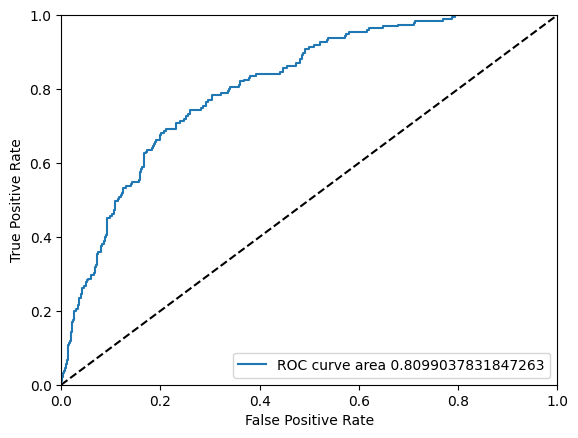

[0.7784090909090909,
 0.5025641025641026,
 0.6242038216560509,
 0.5568181818181819,
 0.8099037831847263]

In [35]:
mlp = MLPClassifier(hidden_layer_sizes=(16,), max_iter=300, random_state=1, solver='sgd')
mlp.fit(x_train_famd, y_train)
y_pred = mlp.predict(x_test_famd)

evaluate(y_test, y_pred, mlp, probs=mlp.predict_proba(x_test_famd))

In [36]:
# Use ANN with best params to filter out incorrectly predicted data

ann1 = MLPClassifier(hidden_layer_sizes=(16,), max_iter=300, random_state=1, solver='sgd')
ann1.fit(x_train_famd, y_train)
ann1_pred = ann1.predict(x_train_famd)  # We are using the train set since we want remove incorrectly predicted data

print(accuracy_score(y_train, ann1_pred))
# it gives around 80% accuracy which means we will remove 20% of the data

# remove outliers
outliers = x_train_famd[ann1_pred != y_train]

# dataset to be feeded to the second ANN
x_train_2 = x_train_famd[ann1_pred == y_train]
y_train_2 = y_train[ann1_pred == y_train]

0.793299620733249


In [ ]:
# Grid Search for second ANN model

param_grid = {
    'hidden_layer_sizes': [(8,), (12,), (16,), (24,), (32,)], # number of neurons in the hidden layer
    'max_iter': [50, 100, 200, 300]  # number of epochs
}

mlp = MLPClassifier(random_state=1, solver='sgd')

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_train_2, y_train_2)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score: ", best_score)

# Best params for accuracy: {'hidden_layer_sizes': (16,), 'max_iter': 300}   0.98 (overfits because we removed missclassified data)
# Best params for recall: {'hidden_layer_sizes': (16,), 'max_iter': 300}    0.94 

Accuracy:  0.78125
Recall:  0.5128205128205128
Precision:  0.6289308176100629
F1:  0.5649717514124294
ROC AUC:  0.7719107349755681
Confusion Matrix: 
 [[450  59]
 [ 95 100]]


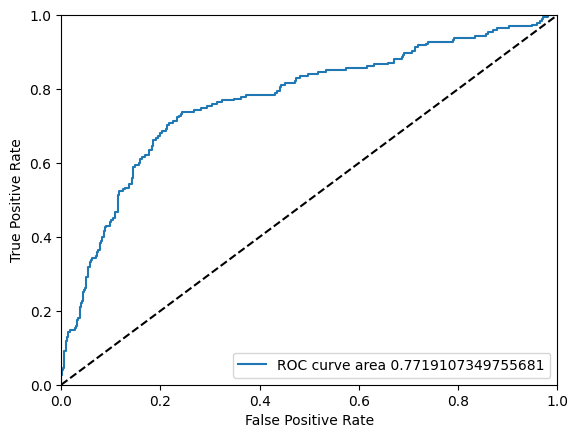

[0.78125,
 0.5128205128205128,
 0.6289308176100629,
 0.5649717514124294,
 0.7719107349755681]

In [37]:
# Evaluating the second ANN model with the best parameters

ann2 = MLPClassifier(hidden_layer_sizes=(16, ), max_iter=300, random_state=1, solver='sgd')
ann2.fit(x_train_2, y_train_2)
ann2_pred = ann2.predict(x_test_famd)

evaluate(y_test, ann2_pred, ann2, probs=ann2.predict_proba(x_test_famd))

Both the baseline ANN and the hybrid ANN+ANN model do not perform better than previously trained models. The hybrid model is slightly better than the baseline model, but the difference is not significant. The hybrid model is also more complex than the baseline model, so it is not worth using it.

### Conclusions

In addressing the problem of customer churn prediction, we evaluated several models and found that the Support Vector Machine model yielded the highest performance, particularly in identifying the largest number of customers likely to churn. This makes it the most suitable model if the top priority is to minimize customer loss. However, to further enhance this model, we could consider hyperparameter tuning using Grid Search. This step was not included in the current study due to computational constraints.

For a more balanced solution, the Voting Classifier ensemble model, which combines Support Vector Machine, Logistic Regression, and Gaussian Naive Bayes, yielded higher accuracy, precision, and F1 scores. Additionally, it maintained a similar ROC AUC score, making it a robust choice when considering a balance between different evaluation metrics

Despite implementing the hybrid neural network approach proposed by Tsai and Lu, we did not observe a significant improvement in the model's performance. This could be attributed to differences between our dataset and the one used in the original study. Possible reasons could include that our dataset is not large enough to effectively train a neural network, that the data does not contain much more information that can be learned, or that we need to apply different feature selection techniques to improve the model's performance.